In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

from pyDOE import *

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

import gpytorch

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP, FixedNoiseGP
from botorch.models.gp_regression_mixed import MixedSingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list, optimize_acqf_mixed
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.objective import GenericMCObjective, ConstrainedMCObjective
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# rest of the training loop
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume

# Sam's work on ref point inferrence & feasibility weighing
from botorch.utils.multi_objective.hypervolume import infer_reference_point
from botorch.acquisition.multi_objective.objective import MCMultiOutputObjective
from botorch.acquisition.utils import get_infeasible_cost
from typing import Optional
from torch import Tensor
from botorch.utils import apply_constraints

# argument for adding feasiility weighting to outcomes
class GenericMCMultiOutputObjective(GenericMCObjective, MCMultiOutputObjective):
    pass

# others
from botorch.exceptions import BadInitialCandidatesWarning
import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

###########

# pymoo dependencies
import pymoo

from pymoo.factory import get_problem
from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_reference_directions, get_termination
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover
from pymoo.optimize import minimize

from pymoo.interface import sample
from pymoo.visualization.scatter import Scatter

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

In [2]:
def optimize_sobol(problem, ref_point, N_BATCH, initial_x,
                   BATCH_SIZE=2,NUM_RESTARTS=20,RAW_SAMPLES=1024,
                   random_state=torch.randint(1000000, (1,)).item(), verbose=False):
    
    print("Optimizing with Sobol")
    
    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    ##########
    
    # original location for an extra HV check wrt to initial samples
    
    ##########

    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
        
        ##########

        # get new random observations for sobol
        new_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=BATCH_SIZE, seed=torch.randint(1000000, (1,)).item()).squeeze(0)
        new_obj, new_con = problem.evaluate(new_x)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        
        # calculate hypervolume based on checks, done on noiseless train_obj and train_con
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)
        
        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        ########## end of iteration loop
    
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")
    
    ##########
    
    # propose feasible candidates
    candidates = []
    
    for i in range(0,int((train_con.size(dim=0)))):
        is_feas_candidate = (train_con[i,...] <= 0).all(dim=-1)  # check whether points fit ALL (.all) constraint criteria
        feas_train_obj_candidate = train_obj[is_feas_candidate] # take only points that fit the 1st check
        if feas_train_obj_candidate.shape[0] > 0:  
            candidates.append(torch.hstack((train_x[i,...], train_obj[i,...])).cpu().numpy())

    print("DONE!\n")
        
    # returns the HV score across iterations, total training set as an array, plus list of feasible candidates
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), candidates

def optimize_qnehvi(problem, ref_point, N_BATCH, initial_x, # must haves
                    BATCH_SIZE=2, custom_batch=None, # you can pick between standard batching or custom tapered
                    feas_weighing=False, eta_relax=False, temp=0.001, # options for weighting, and constraint relaxation
                    NUM_RESTARTS=20,RAW_SAMPLES=1024,
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, standard_bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    model = SingleTaskGP(train_x_gp, train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    
    ##########
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]

    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
        
        ##########
        
        # fit the surrogate model
        fit_gpytorch_model(mll)
        
        ##########
        
        # option for relaxation of constraint sigmoid approximation
        
        if eta_relax is True:
        # value of eta for applying constraints via sigmoid approximation
        # starts as eta=1 (closely approximates constraints) and slowly relaxes to 0.001
            assert len(relax_list) == N_BATCH, "Relaxation values should match no of iterations"
            eta = relax_list[iteration-1]
        else:
            eta = temp
        
        ##########
        
        # option for changing from EIC to feasibility weighted outcomes
        if feas_weighing is True:
                        
            # arguments for defining a feasibility weighted objective wrt to the problem
            infeasible_cost = get_infeasible_cost(X=train_x,
                                                  model=model,
                                                  objective=lambda y: y[..., :problem.n_obj])

            # func to define the weighted objectives on BoTorch's objective class
            def apply_feasibility_weights(Y: Tensor, X: Optional[Tensor] = None) -> Tensor:
                return apply_constraints(obj=Y[..., :problem.n_obj],
                                         constraints=create_idxrs(),
                                         samples=Y,
                                         infeasible_cost=infeasible_cost)
            objective = GenericMCMultiOutputObjective(apply_feasibility_weights)
            
            # define the acqusition function
            acq_func = qNoisyExpectedHypervolumeImprovement(
                model=model,
                ref_point=-ref_point, # for computing HV, must flip for BoTorch
                X_baseline=train_x, # feed total list of train_x for this current iteration
                sampler=SobolQMCNormalSampler(num_samples=128), # determines how candidates are randomly proposed before selection
                objective=objective,
                prune_baseline=True, cache_pending=True) # options for improving qNEHVI, keep these on
            
        else:
            # define the acqusition function for EIC if feas_weighting is false
            acq_func = qNoisyExpectedHypervolumeImprovement(
                model=model,
                ref_point=-ref_point, # for computing HV, must flip for BoTorch
                X_baseline=train_x, # feed total list of train_x for this current iteration
                sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
                objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
                constraints=create_idxrs(), # constraint on last n_constr col
                eta=eta,
                prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # option for tapering BATCH_SIZE
        if custom_batch is not None:
            curr_batch_size = batch_list[iteration-1]
            
        else:
            curr_batch_size = BATCH_SIZE # otherwise takes the BATCH_SIZE argument
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=curr_batch_size, # no of candidates to propose in parallel
                        num_restarts=NUM_RESTARTS, # no of restarts if q candidates fail to show improvement
                        raw_samples=RAW_SAMPLES,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        equality_constraints=problem.equality_constr, # seperate argument for equality constraints, not verified yet   
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])
        
        ##########
        
        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, standard_bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        model = SingleTaskGP(train_x_gp, train_y)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
        
    ##########
    
    # propose feasible candidates
    candidates = []
    
    for i in range(0,int((train_con.size(dim=0)))):
        is_feas_candidate = (train_con[i,...] <= 0).all(dim=-1)  # check whether points fit ALL (.all) constraint criteria
        feas_train_obj_candidate = train_obj[is_feas_candidate] # take only points that fit the 1st check
        if feas_train_obj_candidate.shape[0] > 0:
            candidates.append(torch.hstack((train_x[i,...], train_obj[i,...])).cpu().numpy())

    print("DONE!\n")
    
    # returns the HV score across iterations, total training set as an array, plus list of feasible candidates
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), candidates

def optimize_nsga3(problem, ref_point, N_BATCH, initial_x, # must haves
                   pop_size=100, ref_num=10, # as a rule of thumb, pop_size>ref_num,
                   noise=0, random_state=np.random.randint(0, 1000000, (1,)).item(), verbose=False):
    
    print("Optimizing with UNSGA-III")
    
    t0 = time.time()    
    
    # some initializing
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    
    noise=noise

    # define a pymoo problem class based on the torch class
    class PymooProblem(ElementwiseProblem):

        def __init__(self):
            super().__init__(n_var=problem.n_var,
                             n_obj=problem.n_obj,
                             n_constr=problem.n_constr,
                             xl=problem.bounds[0].cpu().numpy(),
                             xu=problem.bounds[1].cpu().numpy())

        def _evaluate(self, X, out, *args, **kwargs):
            # base input/output from torch class
            train_x = torch.tensor(X.tolist(), **tkwargs).unsqueeze(dim=0)
            
            # take the noisy observations for algo
            train_obj, train_con = problem.evaluate(train_x)
            train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
            train_con_noisy = train_con + noise*torch.randn_like(train_con)

            # output the noisy observations instead
            out["F"] = -train_obj_noisy.cpu().numpy() # flip since botorch assumes maximisation vs pymoo minimization
            out["G"] = train_con_noisy.cpu().numpy()
            
    ##########        

    pymooproblem = PymooProblem()

    # create the reference directions to be used for the optimization
    ref_dirs = get_reference_directions("energy", problem.n_obj, ref_num, seed=random_state)
    
    # initial sampling
    sampling = initial_x.cpu().numpy()
    
    # create the algorithm object
    algorithm = UNSGA3(pop_size=pop_size,
                      ref_dirs=ref_dirs,
                      sampling=sampling
                     )

    # execute the optimization, take N_BATCH+1 since 1st iteration is just the initial sampling
    res = minimize(pymooproblem, algorithm, seed=random_state, termination=('n_gen', N_BATCH+1),
                   verbose=verbose, save_history=True)
    
    ##########
    
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")

    ##########
        
    # calculate hypervolume based on checks, done on noiseless train_obj and train_con
    for i in range(0,N_BATCH):
        train_x = torch.tensor(res.history[i].pop.get("X").tolist(), **tkwargs)
        train_obj, train_con = problem.evaluate(train_x)

        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
    
    ##########
    
    # convert population data into tensor form
    # initial data
    train_x = torch.tensor(res.history[0].pop.get("X").tolist(), **tkwargs)
    train_obj, train_con = problem.evaluate(train_x) 
    # population at each iteration
    for i in range(1,N_BATCH+1): # don't forget we did +1 for total iterations
        new_x = torch.tensor(res.history[i].pop.get("X").tolist(), **tkwargs)
        new_obj, new_con = problem.evaluate(new_x)
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        
    ##########
    
    # propose feasible candidates
    candidates = []
    
    for i in range(0,int((train_con.size(dim=0)))):
        is_feas_candidate = (train_con[i,...] <= 0).all(dim=-1)  # check whether points fit ALL (.all) constraint criteria
        feas_train_obj_candidate = train_obj[is_feas_candidate] # take only points that fit the 1st check
        if feas_train_obj_candidate.shape[0] > 0:
            candidates.append(torch.hstack((train_x[i,...], train_obj[i,...])).cpu().numpy())

    print("DONE!\n")
        
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy(), candidates

In [3]:
dimensions = 8

from botorch.test_functions.multi_objective import C2DTLZ2

LZ2base = C2DTLZ2(dim=dimensions, num_objectives=2, negate=True).to(**tkwargs)

class Problem_LZ2(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 1
    
    bounds = LZ2base.bounds    
    
    def evaluate(X):       
        output = LZ2base(X)
        slack = -LZ2base.evaluate_slack(X)
       
        return output, slack

In [4]:
problem = Problem_LZ2
random_state = 1

(0.0, 1.1)

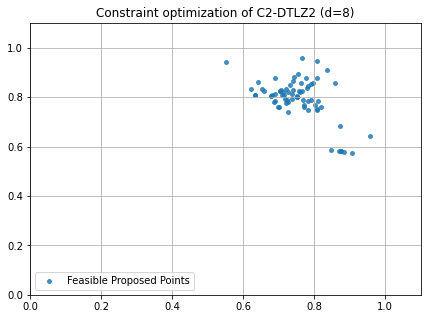

In [5]:
'''
We assume here that the constraints are NOT black-box, but enforceable and known to user
We proceed to randomly generate 1000 virtual samples then virtually optimize with U-NSGA-III to get our feasible sample set
'''

class PymooProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=problem.n_var,
                         n_obj=1,
                         xl=problem.bounds[0].cpu().numpy(),
                         xu=problem.bounds[1].cpu().numpy())

    def _evaluate(self, X, out, *args, **kwargs):
        # base input/output from torch class
        train_x = torch.tensor(X.tolist(), **tkwargs).unsqueeze(dim=0)

        # take the noisy observations for algo
        train_obj, train_con = problem.evaluate(train_x)
        for i in range(train_con.shape[0]):
            if train_con[i]<=0:
                train_con[i] = 0

        out["F"] = train_con.cpu().numpy() # flip since botorch assumes maximisation vs pymoo minimization

##########        

pymooproblem = PymooProblem()

# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("energy", 1, 10, seed=random_state)

# initial sampling
sampling = draw_sobol_samples(bounds=problem.bounds,n=1, q=1000, seed=random_state).squeeze(0).cpu().numpy()

# create the algorithm object
algorithm = UNSGA3(pop_size=8*(problem.n_var+1),
                  ref_dirs=ref_dirs,
                  sampling=sampling
                 )

# execute the optimization, take N_BATCH+1 since 1st iteration is just the initial sampling
res = minimize(pymooproblem, algorithm, seed=random_state, termination=('n_gen', 100+1),
               verbose=False, save_history=True)

'''
The simulated feasible values are then validated to form our initial sample set
'''

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# don't forget to flip back negative if you done so in Problem class definition!
initial_x = torch.tensor(res.history[-1].pop.get("X"), **tkwargs)
initial_obj, initial_con = Problem_LZ2.evaluate(initial_x)

ax.scatter(-initial_obj[...,0].cpu().numpy(),
           -initial_obj[...,1].cpu().numpy(),
           s=15, alpha=0.8, label='Feasible Proposed Points')

ax.legend(loc='lower left')
ax.grid(True)
ax.set_title(f"Constraint optimization of C2-DTLZ2 (d=8)")
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
#ax.set_aspect('equal')

In [6]:
ref_point = torch.tensor([1.1, 1.1], **tkwargs)
noise=0

torch.manual_seed(random_state) # gives a consistent seed based on the trial number
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
hvs = [] # create a blank array to append the scores at each batch/iteration for that run

##########
# generate initial training data for that run
train_x = initial_x
train_obj, train_con = problem.evaluate(train_x)

# add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
train_con_noisy = train_con + noise*torch.randn_like(train_con)

##########

# normalize inputs to [0,1] first before feeding into model
standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
standard_bounds[1] = 1
train_x_gp = normalize(train_x, standard_bounds)

In [7]:
'''
before proceeding with optimization, lets train the model to handle constraints better first
by adding extra constraint data virtually
'''

models = []
for i in range(train_obj_noisy.shape[-1]):
    models.append(
        SingleTaskGP(train_x_gp, train_obj_noisy[..., i:i+1], outcome_transform=Standardize(m=1))
    )
    
con_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=1000, seed=random_state).squeeze(0)
con_obj, con_con = problem.evaluate(con_x)
con_con_noisy = con_con + noise*torch.randn_like(con_con)

virtual_x = torch.cat([train_x, con_x])
virtual_x_gp = normalize(virtual_x, standard_bounds)
virtual_con = torch.cat([train_con_noisy, con_con_noisy])
    
for i in range(virtual_con.shape[-1]):
    models.append(
        SingleTaskGP(virtual_x_gp, virtual_con[..., i:i+1], outcome_transform=Standardize(m=1))
    )

In [10]:
model = ModelListGP(*models)
mll = SumMarginalLogLikelihood(model.likelihood, model)

def create_idxr(i):
    def idxr(Z):
        return Z[..., i]

    return idxr

def create_idxrs():
    return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]

# fit the surrogate model
fit_gpytorch_model(mll)

##########

acq_func = qNoisyExpectedHypervolumeImprovement(
    model=model,
    ref_point=-ref_point, # for computing HV, must flip for BoTorch
    X_baseline=train_x, # feed total list of train_x for this current iteration
    sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
    objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
    constraints=create_idxrs(), # constraint on last n_constr col
    eta=0.001, # enforce very high temperature here
    prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

In [12]:
'''
let's do the first run of qNEHVI here, and see how many feasible samples we get
Here we check for feasibility, enforcing an epsilon/error margin of 0.005

'''
BATCH_SIZE = 8

# propose candidates given defined qNEHVI acq func given model and latest observed training data
new_x, _ = optimize_acqf(
                acq_function=acq_func,
                bounds=standard_bounds, # since train_x was normalized
                q=BATCH_SIZE, # no of candidates to propose in parallel
                num_restarts=20, # no of restarts if q candidates fail to show improvement
                raw_samples=1024,  # pool of samples to choose the starting points from
                options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                )

# unormalize our training inputs back to original problem bounds
new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)
new_obj, new_con = problem.evaluate(new_x)

feas_num = new_con[(new_con<=0.005).all(dim=-1)].shape[0]

print(f"Out of {BATCH_SIZE} samples, only {feas_num} were feasible.")
print(f"{BATCH_SIZE - feas_num} more sample(s) required.")

Out of 8 samples, only 2 were feasible.
6 more sample(s) required.


In [ ]:
'''
Only 5 candidates were feasible, this becomes a conundrum: How would we then batch sample evenly?
We could consider having 2 surrogate models:
1. The primary model (BoTorch GP) which drives qNEHVI acquisition function
2. The secondary model that kicks in when we need to get more samples

Both surrogates are trained from the same initial sample set,
but the secondary model kicks in to provide low-fidelity virtual samples to drive qNEHVI to 'make up' for missing samples
Afterwards, both models are properly trained on the full batch that is validated

To train the secondary model: we can directly port over input x and constraint con,
objective obj will be taken from primary GP

'''

In [ ]:
virtual_pred = model(new_x[(new_con<=0.005).all(dim=-1)]).sample()
virtual_pred

In [ ]:
virtual_pred[...,:problem.n_obj,:]

In [ ]:
virtual_pred[:problem.n_obj].reshape(virtual_pred[:problem.n_obj].shape[0], virtual_pred[:problem.n_obj].shape[1])

In [ ]:
virtual_x = torch.cat([train_x, new_x[(new_con<=0.005).all(dim=-1)]])
virtual_obj = torch.cat([train_obj, new_obj[(new_con<=0.005).all(dim=-1)]])



virtual_con = torch.cat([train_con, new_con[(new_con<=0.005).all(dim=-1)]])



# define and train surrogate models for objective and constraint
model_virtual = SingleTaskGP(train_x_gp, train_y)
mll_virtual = ExactMarginalLogLikelihood(model.likelihood, model)

In [ ]:
new_rand = torch.rand((BATCH_SIZE - feas_num, problem.n_var), **tkwargs)
new_rand

In [ ]:
problem.evaluate(new_rand)

In [ ]:
'''
Only 5 candidates were feasible, this becomes a conundrum: How would we then batch sample evenly?
We could consider having 2 surrogate models:
1. The primary model (BoTorch GP) which drives qNEHVI acquisition function
2. The secondary model that kicks in when we need to get more samples

Both surrogates are trained from the same initial sample set,
but the secondary model kicks in to provide low-fidelity virtual samples to drive qNEHVI to 'make up' for missing samples
Afterwards, both models are properly trained on the full batch that is validated

To train the secondary model: we can directly port over input x and constraint con,
but objective obj doesn't exist yet, we need to find a way to simulate this
'''



In [ ]:

    ##########





    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
    new_con_noisy = new_con + noise*torch.randn_like(new_con)

    # update training points by concatenating the new values into their respective tensors
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])
    train_con = torch.cat([train_con, new_con])
    train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
    train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

    ##########

    # computing HV of current candidate list
    is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
    feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
    if feas_train_obj.shape[0] > 0:
        pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
    else:
        volume = 0.0

    hvs.append(volume)

    ##########

    # update the surrogate models for next iteration
    train_x_gp = normalize(train_x, standard_bounds) # dont forget to renormalize!
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    model = SingleTaskGP(train_x_gp, train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    ##########

    t4 = time.time()
    if verbose:
        print(
                f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                f"{hvs[-1]:>4.2f}, "
                f"time = {t4-t3:>4.2f}s.\n"
                , end="")

    ########## ########## ########## end of iteration loop